<a href="https://colab.research.google.com/github/DavidVollendroff/DS-Unit-1-Sprint-2-Statistics/blob/master/module2/LS_DS_122_Sampling_Confidence_Intervals_and_Hypothesis_Testing_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Assignment - Build a confidence interval

A confidence interval refers to a neighborhood around some point estimate, the size of which is determined by the desired p-value. For instance, we might say that 52% of Americans prefer tacos to burritos, with a 95% confidence interval of +/- 5%.

52% (0.52) is the point estimate, and +/- 5% (the interval $[0.47, 0.57]$) is the confidence interval. "95% confidence" means a p-value $\leq 1 - 0.95 = 0.05$.

In this case, the confidence interval includes $0.5$ - which is the natural null hypothesis (that half of Americans prefer tacos and half burritos, thus there is no clear favorite). So in this case, we could use the confidence interval to report that we've failed to reject the null hypothesis.

But providing the full analysis with a confidence interval, including a graphical representation of it, can be a helpful and powerful way to tell your story. Done well, it is also more intuitive to a layperson than simply saying "fail to reject the null hypothesis" - it shows that in fact the data does *not* give a single clear result (the point estimate) but a whole range of possibilities.

How is a confidence interval built, and how should it be interpreted? It does *not* mean that 95% of the data lies in that interval - instead, the frequentist interpretation is "if we were to repeat this experiment 100 times, we would expect the average result to lie in this interval ~95 times."

For a 95% confidence interval and a normal(-ish) distribution, you can simply remember that +/-2 standard deviations contains 95% of the probability mass, and so the 95% confidence interval based on a given sample is centered at the mean (point estimate) and has a range of +/- 2 (or technically 1.96) standard deviations.

Different distributions/assumptions (90% confidence, 99% confidence) will require different math, but the overall process and interpretation (with a frequentist approach) will be the same.

Your assignment - using the data from the prior module ([congressional voting records](https://archive.ics.uci.edu/ml/datasets/Congressional+Voting+Records)):


### Confidence Intervals:
1. Generate and numerically represent a confidence interval
2. Graphically (with a plot) represent the confidence interval
3. Interpret the confidence interval - what does it tell you about the data and its distribution?

### Chi-squared tests:
4. Take a dataset that we have used in the past in class that has **categorical** variables. Pick two of those categorical variables and run a chi-squared tests on that data
  - By hand using Numpy
  - In a single line using Scipy


In [9]:
import pandas as pd
from scipy import stats

column_headers = ['party','handicapped-infants','water-project',
                          'budget','physician-fee-freeze', 'el-salvador-aid',
                          'religious-groups','anti-satellite-ban',
                          'aid-to-contras','mx-missile','immigration',
                          'synfuels', 'education', 'right-to-sue','crime','duty-free',
                          'south-africa']
data_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/voting-records/house-votes-84.data'

df = pd.read_csv(data_url, header=None, na_values="?", names=column_headers)
df = df.replace({'y':1, 'n': 0})
df.head()

,party,handicapped-infants,water-project,budget,physician-fee-freeze,el-salvador-aid,religious-groups,anti-satellite-ban,aid-to-contras,mx-missile,immigration,synfuels,education,right-to-sue,crime,duty-free,south-africa
0,republican,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,NaN,1.0,1.0,1.0,0.0,1.0
1,republican,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,NaN
2,democrat,NaN,1.0,1.0,NaN,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
3,democrat,0.0,1.0,1.0,0.0,NaN,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
4,democrat,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,NaN,1.0,1.0,1.0,1.0


In [0]:
import numpy as np
import matplotlib.pyplot as plt

def confidence_interval(data, confidence=0.95):
  """
  Calculate a confidence interval around a sample mean for given data.
  Using t-distribution and two-tailed test, default 95% confidence. 
  
  Arguments:
    data - iterable (list or numpy array) of sample observations
    confidence - level of confidence for the interval
  
  Returns:
    tuple of (mean, lower bound, upper bound)
  """
  data = np.array(data)
  mean = np.mean(data)
  n = len(data)
  stderr = np.std(data, ddof=1)/np.sqrt(n)
  moe = stderr * stats.t.ppf((1 + confidence) / 2.0, n - 1)
  return ( mean - moe, mean, mean + moe)

In [28]:
sample_data = df[~df['water-project'].isnull()]['water-project']
confidence_interval(sample_data)

(0.45384081311663604, 0.5038759689922481, 0.5539111248678601)

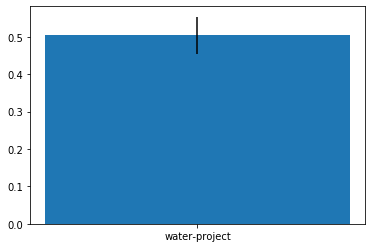

In [41]:
import seaborn as sns
fig, ax = plt.subplots()

CI = confidence_interval(sample_data)
ax.bar(x='water-project',height=CI[1], yerr=CI[1]-CI[0])

plt.show()

My interpretation of the data with confidence interval included would be that my best guess for the mean level of support among the population whose representative members are members of the House of Representatives is the single value of the bar's height. And if I were to perform this same vote sampling twenty times from the population the voters were supposedly drawn from, I would expect to see that subsequent individual estimates of the true mean would fall within the margins of the error bar nineteen of those twenty times.

### Chi-squared tests:
Take a dataset that we have used in the past in class that has **categorical** variables. Pick two of those categorical variables and run a chi-squared tests on that data
  
  

In [43]:
# get the data
!wget https://resources.lendingclub.com/LoanStats_2018Q4.csv.zip
!unzip LoanStats_2018Q4.csv.zip

# load the data into a dataframe, respecting header placement, ignoring the
# excess information in the tail and suppressing the warning regarding the c
# engine with our kwargs
df = pd.read_csv('LoanStats_2018Q4.csv', header=1, skipfooter=2, engine='python')
df.head()

--2019-11-05 21:15:29--  https://resources.lendingclub.com/LoanStats_2018Q4.csv.zip
Resolving resources.lendingclub.com (resources.lendingclub.com)... 64.48.1.20
Connecting to resources.lendingclub.com (resources.lendingclub.com)|64.48.1.20|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘LoanStats_2018Q4.csv.zip’

LoanStats_2018Q4.cs     [          <=>       ]  21.67M   802KB/s    in 28s     

2019-11-05 21:15:58 (788 KB/s) - ‘LoanStats_2018Q4.csv.zip’ saved [22727580]

Archive:  LoanStats_2018Q4.csv.zip
  inflating: LoanStats_2018Q4.csv    


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,...,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,NaN,NaN,35000,35000,35000.0,36 months,14.47%,1204.23,C,C2,Staff Physician,8 years,MORTGAGE,360000.0,Verified,Dec-2018,Fully Paid,n,NaN,NaN,credit_card,Credit card refinancing,336xx,FL,19.90,0,Apr-1995,1,NaN,NaN,24,0,57259,43.2%,51,w,0.00,0.00,38187.046837,38187.05,...,30.8,0,0,1222051,169286,124600,258401,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,5000,5000,5000.0,36 months,22.35%,191.86,D,D5,Director of Sales,10+ years,MORTGAGE,72000.0,Source Verified,Dec-2018,Fully Paid,n,NaN,NaN,debt_consolidation,Debt consolidation,333xx,FL,20.12,0,Mar-2010,0,NaN,NaN,13,0,11720,47.1%,26,f,0.00,0.00,5615.977674,5615.98,...,50.0,0,0,218686,34418,18200,37786,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,10000,10000,10000.0,60 months,23.40%,284.21,E,E1,NaN,< 1 year,RENT,55000.0,Source Verified,Dec-2018,Current,n,NaN,NaN,debt_consolidation,Debt consolidation,902xx,CA,13.51,0,Apr-2007,0,44.0,88.0,9,1,11859,53.9%,11,w,9131.55,9131.55,2538.390000,2538.39,...,100.0,1,0,34386,21235,10500,12386,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,17100,17100,17100.0,36 months,18.94%,626.30,D,D2,Receptionist,10+ years,RENT,38000.0,Verified,Dec-2018,Current,n,NaN,NaN,debt_consolidation,Debt consolidation,150xx,PA,38.09,0,Mar-1998,1,47.0,NaN,14,0,15323,53%,21,w,13682.21,13682.21,5609.710000,5609.71,...,75.0,0,0,70954,43351,16600,41784,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,4000,4000,4000.0,36 months,10.72%,130.43,B,B2,Extrusion assistant,10+ years,MORTGAGE,56000.0,Verified,Dec-2018,Current,n,NaN,NaN,credit_card,Credit card refinancing,301xx,GA,31.03,0,Sep-2006,0,NaN,NaN,7,0,4518,28.6%,11,w,3116.62,3116.62,1160.780000,1160.78,...,0.0,0,0,221310,71375,12300,77865,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN


In [44]:
df.describe(exclude='number')

,term,int_rate,grade,sub_grade,emp_title,emp_length,home_ownership,verification_status,issue_d,loan_status,pymnt_plan,purpose,title,zip_code,addr_state,earliest_cr_line,revol_util,initial_list_status,last_pymnt_d,next_pymnt_d,last_credit_pull_d,application_type,verification_status_joint,sec_app_earliest_cr_line,hardship_flag,hardship_type,hardship_reason,hardship_status,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_loan_status,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date
count,128412,128412,128412,128412,107465,116708,128412,128412,128412,128412,128412,128412,128412,128412,128412,128412,128256,128412,128253,108949,128411,128412,14848,16782,128412,96,96,96,96,96,96,96,128412,215,215,215
unique,2,46,7,35,43892,11,4,3,3,7,2,12,12,880,50,644,1074,2,13,3,14,2,3,573,2,1,8,3,5,7,5,4,2,8,3,9
top,36 months,13.56%,A,A4,Teacher,10+ years,MORTGAGE,Not Verified,Oct-2018,Current,n,debt_consolidation,Debt consolidation,112xx,CA,Aug-2006,0%,w,Sep-2019,Oct-2019,Oct-2019,Individual,Not Verified,Aug-2006,N,INTEREST ONLY-3 MONTHS DEFERRAL,UNEMPLOYMENT,ACTIVE,Sep-2019,Dec-2019,Oct-2019,Late (16-30 days),N,Sep-2019,ACTIVE,Sep-2019
freq,88179,6972,38011,9770,2090,38826,63490,58350,46305,104752,128354,70603,70603,1370,17879,1130,1132,114498,73941,68725,114138,111630,6360,155,128322,96,32,90,42,47,47,40,128197,58,194,59


In [45]:
df['emp_length'].value_counts()

10+ years    38826
< 1 year     16036
2 years      10857
3 years      10038
1 year        9067
5 years       7737
4 years       7474
6 years       5422
7 years       4374
8 years       4104
9 years       2773
Name: emp_length, dtype: int64

In [46]:
df['loan_status'].value_counts()

Current               104752
Fully Paid             16600
Charged Off             2863
Late (31-120 days)      2557
In Grace Period          755
Late (16-30 days)        668
Default                  217
Name: loan_status, dtype: int64

  - By hand using Numpy

In [47]:
contingency_table = pd.crosstab(df['emp_length'], df['loan_status'], margins=True)

contingency_table

loan_status,Charged Off,Current,Default,Fully Paid,In Grace Period,Late (16-30 days),Late (31-120 days),All
emp_length,,,,,,,,
1 year,188,7399,18,1151,67,49,195,9067
10+ years,722,31661,61,5370,197,186,629,38826
2 years,201,8900,15,1396,48,53,244,10857
3 years,236,8180,10,1313,43,52,204,10038
4 years,169,6023,13,1022,46,49,152,7474
5 years,173,6279,14,1008,60,32,171,7737
6 years,108,4406,10,737,34,22,105,5422
7 years,87,3546,7,608,23,22,81,4374
8 years,84,3353,4,541,17,32,73,4104


In [67]:
# Calculate row and column totals to use in the expected value calculations
row_sums = contingency_table['All'].values
row_sums = row_sums[:-1]
col_sums = contingency_table.iloc[-1, :-1].values

print(row_sums)
#print(row_sums_easy_way)
print(col_sums)

[ 9067 38826 10857 10038  7474  7737  5422  4374  4104  2773 16036]
[ 2487 95324   185 15172   675   602  2263]


In [73]:
total = contingency_table.loc['All','All']
total

116708

In [74]:
expected = []
for i in range(len(row_sums)):
  expected_row = []
  for column in col_sums:
    expected_val = column*row_sums[i]/total
    expected_row.append(expected_val)
  expected.append(expected_row)

expected = np.array(expected)
observed = pd.crosstab(df['emp_length'], df['loan_status']).values
print(expected.shape)
print(observed.shape)

(11, 7)
(11, 7)


In [81]:
chi_squared = ((observed-expected)**2/expected).sum()
dof = (len(row_sums)-1)*(len(col_sums)-1)
print('Chi Squared Value: {}  Degrees of Freedom: {}'.format(chi_squared, dof))
print('Associated P-Value of: {}'.format(stats.distributions.chi2.sf(chi_squared, dof)))


Chi Squared Value: 296.64276171431374  Degrees of Freedom: 60
Associated P-Value of: 4.975451908403232e-33


  - In a single line using Scipy

In [80]:
chi_squared, p_value, dof, expected = stats.chi2_contingency(pd.crosstab(df['emp_length'], df['loan_status']))
print('Chi Squared Value: {} Degrees of Freedom: {}'.format(chi_squared, dof))
print('P-Value: {}'.format(p_value))

Chi Squared Value: 296.64276171431374 Degrees of Freedom: 60
P-Value: 4.975451908403232e-33


## Stretch goals:

1. Write a summary of your findings, mixing prose and math/code/results. *Note* - yes, this is by definition a political topic. It is challenging but important to keep your writing voice *neutral* and stick to the facts of the data. Data science often involves considering controversial issues, so it's important to be sensitive about them (especially if you want to publish).
2. Apply the techniques you learned today to your project data or other data of your choice, and write/discuss your findings here.
3. Refactor your code so it is elegant, readable, and can be easily run for all issues.

## Resources

- [Interactive visualize the Chi-Squared test](https://homepage.divms.uiowa.edu/~mbognar/applets/chisq.html)
- [Calculation of Chi-Squared test statistic](https://en.wikipedia.org/wiki/Pearson%27s_chi-squared_test)
- [Visualization of a confidence interval generated by R code](https://commons.wikimedia.org/wiki/File:Confidence-interval.svg)
- [Expected value of a squared standard normal](https://math.stackexchange.com/questions/264061/expected-value-calculation-for-squared-normal-distribution) (it's 1 - which is why the expected value of a Chi-Squared with $n$ degrees of freedom is $n$, as it's the sum of $n$ squared standard normals)